# Damage Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from xview2comp.nb_02d import *

### Data

In [3]:
#export
CATS = ['nun', 'minor', 'major', 'destroyed']

In [4]:
SOURCE = Path('data/train')
SOURCE.ls()

[PosixPath('data/train/classification_images'),
 PosixPath('data/train/binarymasks'),
 PosixPath('data/train/labels'),
 PosixPath('data/train/images')]

In [153]:
annots = pd.read_csv('class_labels_combined_gpu.csv')

In [154]:
annots.shape

(94313, 4)

In [155]:
annots = annots.sample(90000)

In [156]:
annots.damage.value_counts()

minor        24527
destroyed    22510
nun          22489
major        20474
Name: damage, dtype: int64

In [157]:
fnames = list(annots.file)
fnames[:3]

['data/train/classification_images/325ab0fc-2b67-4a2b-965e-4233621caa44.png',
 'data/train/classification_images/37a1886d-edb3-4b14-93c0-03d61c56f12f.png',
 'data/tier3/classification_images/c1165195-7a55-49d1-b9f9-051c8556fe50.png']

### LabeledData

In [158]:
val_idx = get_random_val_idx(len(fnames), val_pct=.2)

In [159]:
%%time
_dict_file2damage = {f:d for f,d in zip(annots.file, annots.damage)}

CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 48.2 ms


In [160]:
#export
def get_label(fname): return _dict_file2damage[fname]

In [161]:
%%time
src = (ImageList(fnames)
       .split_by_idx(val_idx)
       .label_from_func(get_label, classes=CATS))

CPU times: user 108 ms, sys: 0 ns, total: 108 ms
Wall time: 106 ms


In [162]:
src

LabelLists;

Train: LabelList (72000 items)
x: ImageList
Image (3, 81, 110),Image (3, 81, 69),Image (3, 100, 24),Image (3, 38, 51),Image (3, 58, 58)
y: CategoryList
major,minor,destroyed,major,nun
Path: .;

Valid: LabelList (18000 items)
x: ImageList
Image (3, 55, 52),Image (3, 65, 64),Image (3, 11, 52),Image (3, 19, 42),Image (3, 116, 74)
y: CategoryList
destroyed,nun,major,destroyed,destroyed
Path: .;

Test: None

### Training

In [203]:
bs = 32
sz = 299 #64 #512
#tfms = get_transforms(flip_vert=True, max_rotate=.2, max_warp=0., max_zoom=1.1, max_lighting=.4)
tfms = ([
        flip_lr(p=0.5),
        brightness(change=(0.4,0.6)),
        contrast(scale=(0.7,1.3))
    ], [])

data = (src.transform(tfms, size=sz)#.presize(sz, scale=(0.25, 1.0))
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [204]:
#idx = 18
#data.valid_ds.x[idx].show()
#print(data.valid_ds.y[idx], data.valid_ds.items[idx], sep='\n')

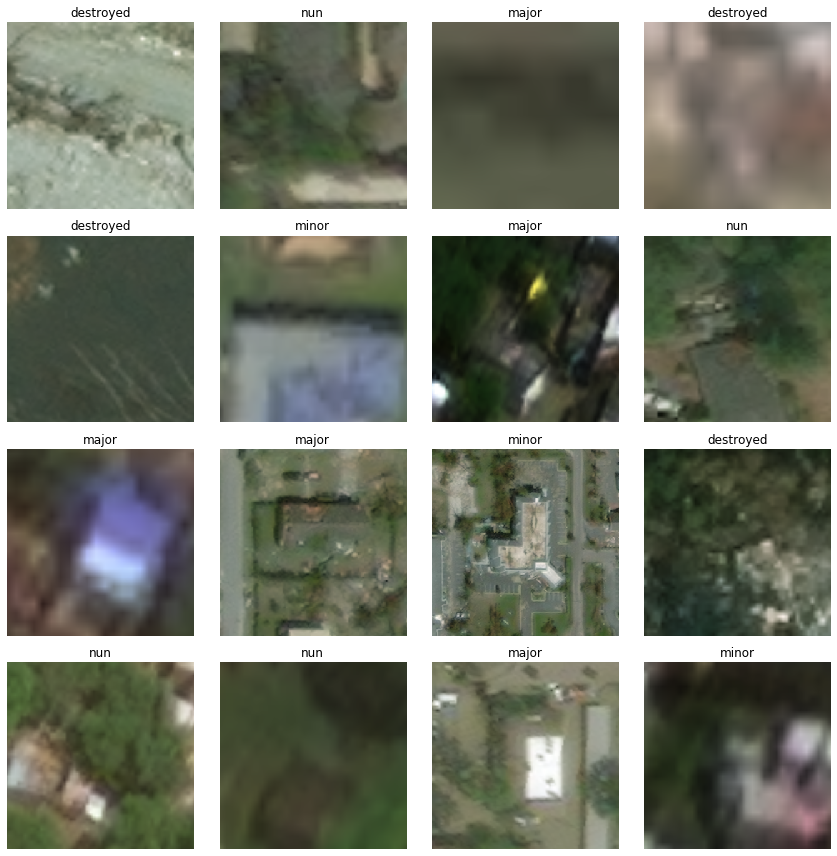

In [205]:
data.show_batch(rows=4, figsize=(12, 12), ds_type=DatasetType.Valid)

In [211]:
cb_funcs = [partial(callbacks.SaveModelCallback, monitor='accuracy', mode='max', every='improvement', name='best_model'),]
metrics = [accuracy] 
learn = cnn_learner(data, models.resnet152, metrics=metrics,
                    callback_fns=cb_funcs, wd=0., ps=0.)
                    #loss_func=LabelSmoothingCrossEntropy()).mixup(alpha=.2)
#learn.to_fp16(dynamic=True);

In [212]:
learn.load('best_model_damg_nsample94313_sz299_bs32_resnet152');

In [217]:
learn.export('best_model_damg_nsample94313_sz299_bs32_resnet152.pkl');

In [177]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


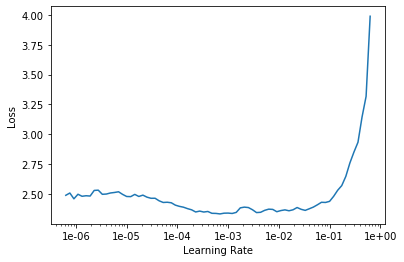

In [178]:
learn.recorder.plot()

In [183]:
learn.fit_one_cycle(cyc_len=80, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.901474,1.297680,0.511611,03:35
1,1.806402,1.220389,0.548444,03:35
2,1.727720,1.179176,0.570722,03:35
3,1.670341,1.126114,0.593833,03:34
4,1.601335,1.087451,0.604000,03:34
5,1.497211,1.052271,0.624056,03:35
6,1.416202,1.015127,0.639000,03:35
7,1.353584,0.983679,0.652333,03:35
8,1.225402,0.959952,0.667500,03:35
9,1.173572,0.935987,0.681167,03:35


Better model found at epoch 0 with accuracy value: 0.5116111040115356.
Better model found at epoch 1 with accuracy value: 0.5484444499015808.
Better model found at epoch 2 with accuracy value: 0.570722222328186.
Better model found at epoch 3 with accuracy value: 0.593833327293396.
Better model found at epoch 4 with accuracy value: 0.6039999723434448.
Better model found at epoch 5 with accuracy value: 0.6240555644035339.
Better model found at epoch 6 with accuracy value: 0.6389999985694885.
Better model found at epoch 7 with accuracy value: 0.6523333191871643.
Better model found at epoch 8 with accuracy value: 0.6675000190734863.
Better model found at epoch 9 with accuracy value: 0.6811666488647461.
Better model found at epoch 10 with accuracy value: 0.6944444179534912.
Better model found at epoch 11 with accuracy value: 0.6977221965789795.
Better model found at epoch 12 with accuracy value: 0.711722195148468.
Better model found at epoch 13 with accuracy value: 0.7167222499847412.
Bette

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 21 with accuracy value: 0.7491666674613953.
Better model found at epoch 22 with accuracy value: 0.7516666650772095.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 26 with accuracy value: 0.7549444437026978.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 31 with accuracy value: 0.7611666917800903.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 34 with accuracy value: 0.7642777562141418.
Better model found at epoch 35 with accuracy value: 0.7649444341659546.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 44 with accuracy value: 0.769444465637207.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 56 with accuracy value: 0.770111083984375.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Better model found at epoch 65 with accuracy value: 0.7710555791854858.
Better model found at epoch 66 with accuracy value: 0.7718889117240906.


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



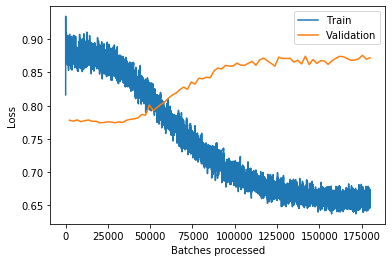

In [194]:
learn.recorder.plot_losses()

In [201]:
learn.load('stage2_best_model_damg_nsample90000_sz128_bs32_resnet50_tfms_mixup_labsmooth');

In [202]:
learn.export('stage2_best_model_damg_nsample90000_sz128_bs32_resnet50_tfms_mixup_labsmooth.pkl');

### Classification results

best_model_damg_nsample10000_sz299_bs32_resnet152 ----- 4 	1.027053 	1.055706 	0.275000 	0.725237 	03:25
best_model_damg_nsample10000_sz299_bs32_resnet152_tfms_mixup_labelsmooth ----- 5 	0.973839 	0.910530 	0.305500 	0.693718 	03:26

best_model_damg_nsample30000_sz299_bs32_resnet152  ---- 4 	0.497787 	0.636151 	0.203833 	0.796178 	10:11

best_model_damg_nsample36000_sz299_bs32_resnet152 ----- 0 	0.588692 	0.509510 	0.161528 	0.838523 	12:13

**best_model_damg_nsample42000_sz299_bs32_resnet152** ----- 0 	0.560124 	0.495904 	0.155952 	0.843830 	14:18

best_model_damg_nsample55000_sz299_bs32_resnet152 ----- 0 	0.545310 	0.468869 	0.158727 	0.841003 	13:51

best_model_damg_nsample94313_sz299_bs32_resnet152 ----- 0 	0.550715 	0.473009 	0.158255 	0.841745 	23:57

best_model_damg_nsample94313_sz299_bs32_resnet152_tfms_mixup_labsmooth_wd ----- 0 	1.522005 	0.975263 	0.169388 	0.830748 	32:18

20epochs_model_damg_nsample94313_sz299_bs32_resnet152_tfms_mixup_labsmooth_wd ----- 19 	0.897858 	0.735694 	0.203425 	0.796434 	32:06

best_model_damg_nsample55000_sz224_bs64_resnet152_fp16 ----- 0 	0.323151 	0.612834 	0.230909 	0.768898 	10:36

1. classifier_maxsz128_sz32_bs64_resnet50_tfmsNone_stage1 ----- 39 	0.758440 	1.137212 	0.382500 	00:05
2. classifier_maxsz128_sz32_bs64_resnet50_tfmsNone_stage2 ----- 39 	0.643406 	1.045906 	0.390000 	00:06

1. classifier_maxsz128_sz64_bs32_resnet50_tfmsNone_stage1 ----- 39 	0.640366 	1.002563 	0.320000 	00:09
2. classifier_maxsz128_sz64_bs32_resnet50_tfmsNone_stage1 ----- 39 	0.520865 	0.978961 	0.331250 	00:12

1. classifier_maxsz128_sz128_bs16_resnet50_tfmsNone_stage1 -- 39 	0.730958 	0.760683 	0.267500 	00:50
2. classifier_maxsz128_sz128_bs16_resnet50_tfmsNone_stage2 -- 9 	0.554020 	0.782075 	0.280500 	01:03

1. classifier_sz64_bs16_resnet50_stage1 ----- 19 	0.887879 	0.600300 	0.237990 	00:45
2. classifier_sz64_bs16_resnet50_stage2 ----- 19 	0.818543 	0.574872 	0.229120 	00:58
3. classifier_sz128_bs16_resnet50_stage1 ---- 19 	0.890955 	0.617753 	0.235772 	00:46


1. classifier_sz128_bs64_resnet50_stage1 ----- 19 	0.794813 	0.513871 	0.188470 	00:18

1. classifier_sz128_bs64_resnet101_stage1 ----- 19 	0.885585 	0.722650 	0.237251 	00:31
2. classifier_sz128_bs64_resnet101_stage2 ----- 39 	0.813070 	0.773460 	0.201774 	00:44

1. classifier_sz128_bs64_resnet101_tfmsNone_stage1 ----- 19 	0.595315 	0.578356 	0.201774 	00:31
2. classifier_sz128_bs64_resnet101_tfmsNone_stage2 ----- 39 	0.459314 	0.549257 	0.187731 	00:44

1. classifier_sz256_bs64_resnet101_tfmsNone_stage1 ----- 29 	0.515034 	0.652625 	0.205469 	01:37


### Results interpretation

In [213]:
interp = ClassificationInterpretation.from_learner(learn)

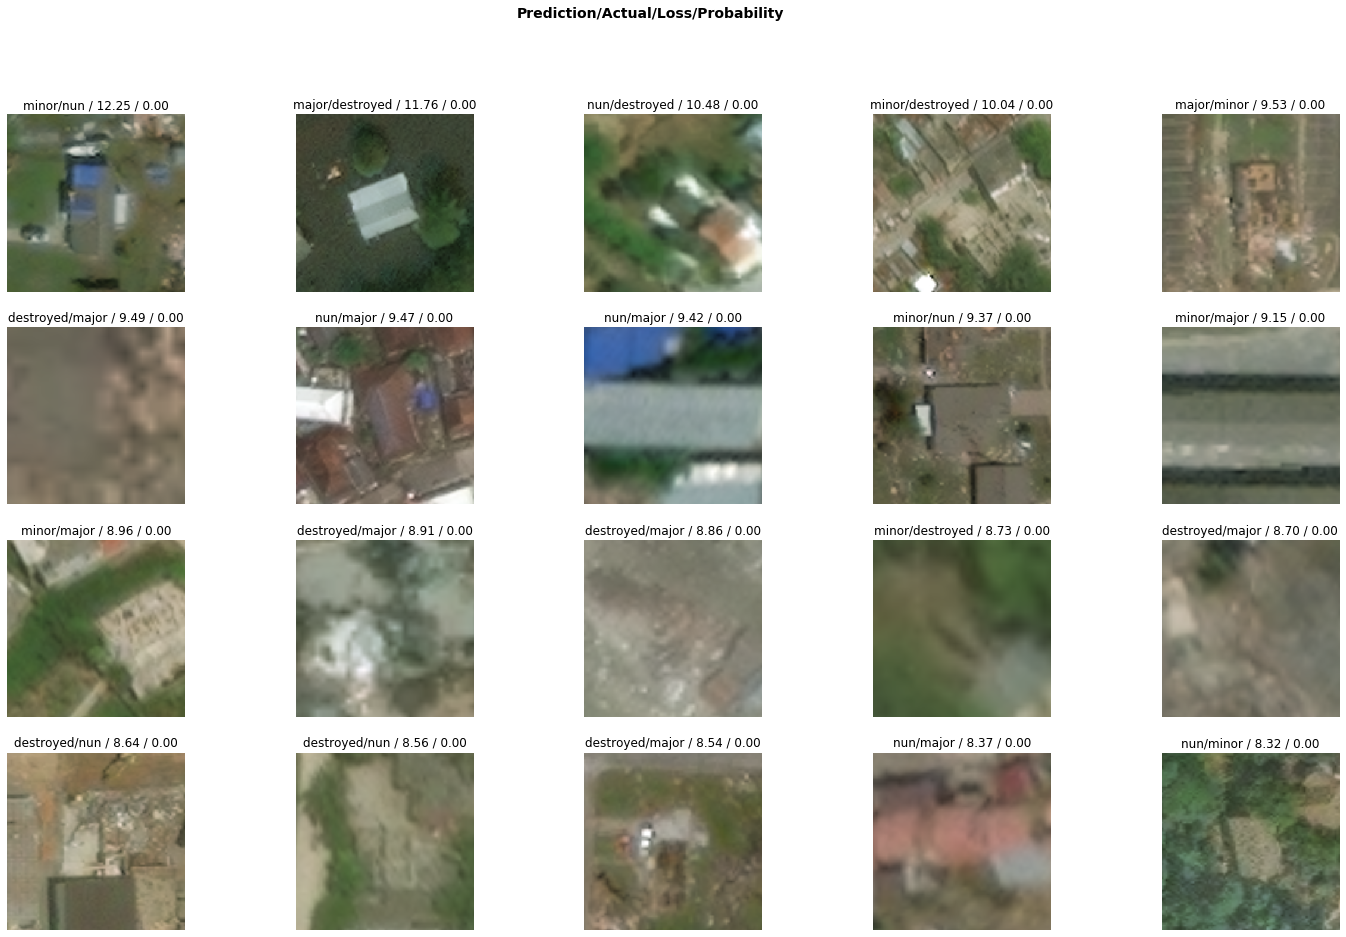

In [214]:
interp.plot_top_losses(20, figsize=(25, 15))

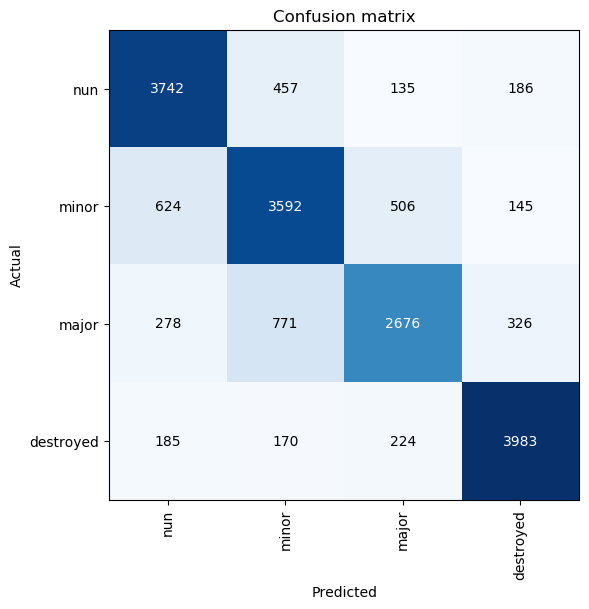

In [215]:
interp.plot_confusion_matrix(figsize=(6, 6), dpi=100)

In [216]:
interp.most_confused(min_val=2)

[('major', 'minor', 771),
 ('minor', 'nun', 624),
 ('minor', 'major', 506),
 ('nun', 'minor', 457),
 ('major', 'destroyed', 326),
 ('major', 'nun', 278),
 ('destroyed', 'major', 224),
 ('nun', 'destroyed', 186),
 ('destroyed', 'nun', 185),
 ('destroyed', 'minor', 170),
 ('minor', 'destroyed', 145),
 ('nun', 'major', 135)]

### Infer on single image

In [101]:
idx = 15
img = open_image(data.valid_ds.items[idx])

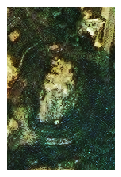

In [102]:
img.show()

In [103]:
learn.predict(img)

(Category destroyed, tensor(3), tensor([0.0191, 0.0238, 0.0128, 0.9443]))

### Infer on 10 images

In [87]:
preds, pred_classes = [], []
for fn in progress_bar(data.valid_ds.items[:10]):
    img = open_image(fn)
    pred_class, pred_idx, outputs = learn.predict(img)
    preds.append(list(to_np(outputs)))
    pred_classes.append(str(pred_class))

In [88]:
uids = [o.stem for o in list(data.valid_ds.items[:10])]

In [89]:
pd.DataFrame({'uid':uids, 'pred_class':pred_classes})

,uid,pred_class
0,7be7d8a9-d284-4e42-8793-ce7b7b588219,no-damage/un-classified
1,0d187a0d-398b-4339-a54a-27695ffdfee3,no-damage/un-classified
2,dbc44cd2-b613-4495-8a43-8fff5f7f386a,no-damage/un-classified
3,e2ea9772-491c-4175-8f46-0d45dd404ebc,no-damage/un-classified
4,c1282575-3ca1-4965-a949-afecb9a00c56,major-damage
5,d3dfe5d5-9961-467f-a1ac-e0c84f33cd96,no-damage/un-classified
6,2ed65af9-5dfc-47e1-be2c-a9f7d4eeb0ca,no-damage/un-classified
7,e8cfe949-936a-4d40-a176-f22f739be4d3,no-damage/un-classified
8,1bff6b4e-fdca-4ee4-a5a9-9cd28db8eaab,no-damage/un-classified
9,373fb963-c81b-4770-ad49-bc9dc3ad2e6c,no-damage/un-classified


### Infer single image (`load_learner`)

In [92]:
load_learn = load_learner('./', file='damage_classifier.pkl')

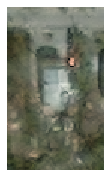

In [96]:
idx = 15
img = open_image(data.valid_ds.items[idx])
img.show()

In [97]:
load_learn.predict(img)

(Category no-damage/un-classified,
 tensor(0),
 tensor([0.8909, 0.0076, 0.0885, 0.0130]))

### Infer on 10 images (`load_learner`)

In [98]:
load_learn = load_learner('./', file='damage_classifier.pkl')

In [99]:
preds, pred_classes = [], []
for fn in progress_bar(data.valid_ds.items[:10]):
    img = open_image(fn)
    pred_class, pred_idx, outputs = load_learn.predict(img)
    preds.append(list(to_np(outputs)))
    pred_classes.append(str(pred_class))

In [101]:
pd.DataFrame({'uid':uids, 'pred_class':pred_classes})

,uid,pred_class
0,7be7d8a9-d284-4e42-8793-ce7b7b588219,no-damage/un-classified
1,0d187a0d-398b-4339-a54a-27695ffdfee3,no-damage/un-classified
2,dbc44cd2-b613-4495-8a43-8fff5f7f386a,no-damage/un-classified
3,e2ea9772-491c-4175-8f46-0d45dd404ebc,no-damage/un-classified
4,c1282575-3ca1-4965-a949-afecb9a00c56,major-damage
5,d3dfe5d5-9961-467f-a1ac-e0c84f33cd96,no-damage/un-classified
6,2ed65af9-5dfc-47e1-be2c-a9f7d4eeb0ca,no-damage/un-classified
7,e8cfe949-936a-4d40-a176-f22f739be4d3,no-damage/un-classified
8,1bff6b4e-fdca-4ee4-a5a9-9cd28db8eaab,no-damage/un-classified
9,373fb963-c81b-4770-ad49-bc9dc3ad2e6c,no-damage/un-classified


### Infer 10 images (`load_learner` and `get_preds`)

In [105]:
il = ImageList(data.valid_ds.items[:10])

In [106]:
load_learn = load_learner('./', file='damage_classifier.pkl', test=il)

In [107]:
pred_damg, y_damg = load_learn.get_preds(ds_type=DatasetType.Test)

In [111]:
pred_damg.argmax(dim=1)

tensor([0, 0, 0, 0, 2, 0, 0, 0, 0, 0])

In [110]:
outputs

tensor([0.9100, 0.0037, 0.0434, 0.0429])

# -fin

In [20]:
! python notebook2script.py 03_damage_classification.ipynb

Converted 03_damage_classification.ipynb to xview2comp/nb_03.py
